# Download das bibliotecas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import spacy
import nltk
nltk.download('stopwords')

In [ ]:
!python -m spacy download pt_core_news_sm

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import pt_core_news_sm
from nltk.corpus import stopwords
from gensim.models import Word2Vec, KeyedVectors
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Fontes de dados

## Criação da tabela de reclamações

> O conteúdo das reclamações pode conter dados sensíveis de clientes, como nome completo, endereço ou número do documento. Por este motivo, a tabela crua do banco de dados ("Reclamações.xlsx") não será fornecida. Os textos das reclamações da tabela crua passaram pelo processo de tokenização e vetorização. Sendo assim, será disponibilizado apenas os modelos de vetor, matriz de vetores e labels. O registro abaixo é o pipeline com a base de dados original.

In [ ]:
df_reclamacoes = pd.read_excel("/content/Reclamações.xlsx")

In [103]:
df_reclamacoes.sample(5)

,CD_SERVICO,DS_SOLICITACAO
20968,5803,OS gerada por desdobramento da OS 9812165.\nVe...
12981,3803,Verificar vazamento conforme dados abaixo.\nTi...
19744,5803,OS gerada por desdobramento da OS 9107833.\nTi...
11483,3802,Verificar falta de água conforme dados abaixo....
5498,3802,Verificar falta de água conforme dados abaixo....


> O seguinte método visa obter o que foi descrito pelo cliente de dentro do corpo do texto de solicitação de abertura de reclamação.

In [ ]:
def trata_texto(codigo, texto_cru):
  texto_tratado = None

  if codigo in (5803, 2910, 1271, 1252, 1238, 1237, 1236, 1226, 1214, 1213):
    termo = "Adicional:"
    index = texto_cru.rfind(termo)
    if index > 0:
      texto_tratado = texto_cru[index + len(termo):]

  elif codigo == 3803:
    termo = "Adicional:"
    tipo_1_index = texto_cru.rfind(termo)
    if tipo_1_index > 0:
      texto_tratado = texto_cru[tipo_1_index + len(termo):]
    else:
      termo = "|"
      tipo_2_index = texto_cru.rfind(termo)
      if tipo_2_index > 0:
        texto_tratado = texto_cru[tipo_2_index + len(termo):]

  elif codigo == 3802:
    termo = "Adicional:"
    tipo_1_index = texto_cru.rfind(termo)
    if tipo_1_index > 0:
      texto_tratado = texto_cru[tipo_1_index + len(termo):]
    else:
      termo = "Observação:"
      tipo_2_index = texto_cru.rfind(termo)
      if tipo_2_index > 0:
        texto_tratado = texto_cru[tipo_2_index + len(termo):]

  elif codigo == 2017:
    termo_inicial = "Justificativa:"
    inicio_index = texto_cru.rfind(termo_inicial)

    termo_final = "Fatura(s):"
    final_index = texto_cru.rfind(termo_final)

    if (inicio_index > 0) and (final_index > 0):
      texto_tratado = texto_cru[inicio_index + len(termo_inicial) : final_index]

  elif codigo == 1015:
    termo = "Dados do ocorrido:"
    index = texto_cru.rfind(termo)
    if index > 0:
      texto_tratado = texto_cru[index + len(termo):]

  return texto_tratado

In [ ]:
codigos_e_textos = []
for index, row in df_reclamacoes.iterrows():
  texto_encontrado = trata_texto(row["CD_SERVICO"], row["DS_SOLICITACAO"])
  if texto_encontrado:
    codigos_e_textos.append((row["CD_SERVICO"], texto_encontrado))

textos_encontrados = pd.DataFrame(codigos_e_textos, columns=['Código do serviço', 'Texto'])

In [ ]:
textos_encontrados.shape
# (14651, 2)

## União com a tabela de categorias

In [11]:
ctg_reclamacoes = pd.read_excel("/content/Categorias - Reclamações.xlsx")
ctg_reclamacoes.sample(10)

,Código do serviço,Categoria
22,1214,Obras
43,1561,Serviços - Qualidade
1,3802,Abastecimento
39,1238,Serviços - Qualidade
27,1271,Outros
35,1252,Serviços - Prazo
16,10004,Fatura
2,3804,Abastecimento
10,10018,Fatura
29,1226,Repavimentação


In [ ]:
df_reclamacoes = textos_encontrados.merge(ctg_reclamacoes, on ="Código do serviço", how="left")

In [27]:
df_reclamacoes.sample(5)

,Código do serviço,Texto,Categoria
3754,3802,"Sem água desde cedo , era para faltar amanhã...",Abastecimento
6986,3802,"Houve quebra no registro entrada da água , a...",Abastecimento
8945,3802,Nossa caixa água esvaziou .,Abastecimento
3953,3802,"Possui água , mas a pressão está fraca demai...",Abastecimento
8422,3802,Todos os dias e não resolvem,Abastecimento


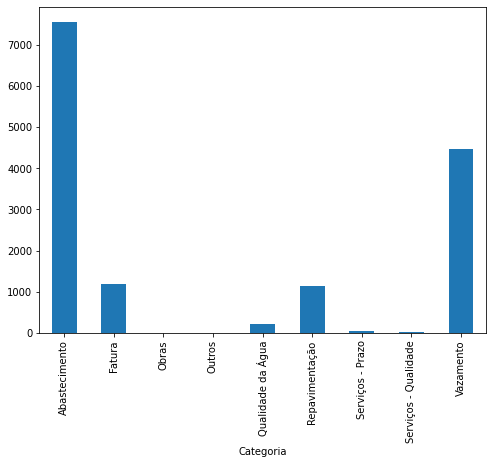

In [21]:
fig = plt.figure(figsize=(8,6))
df_reclamacoes.groupby('Categoria').Texto.count().plot.bar()
plt.show()

# Engenharia de recursos

## Tokenização

In [22]:
nlp = pt_core_news_sm.load(disable=["lemmatizer", "parser", "textcat", "ner"])
stop_words = stopwords.words('portuguese')

def tokenizador(texto):
  texto = texto.replace("\n", " ")
  doc = nlp(texto)

  postags_nao_permitidas = set(['SYM', 'PUNCT', 'DET', 'ADP'])
  tokens_validos = []
  for i, token in enumerate(doc):
      eh_valido = (token.text not in stop_words) and token.is_alpha and (token.pos_ not in postags_nao_permitidas) 
      if eh_valido:
        tokens_validos.append(token.text.lower())

  return tokens_validos

In [23]:
df_reclamacoes["Tokens"] = df_reclamacoes["Texto"].apply(tokenizador)

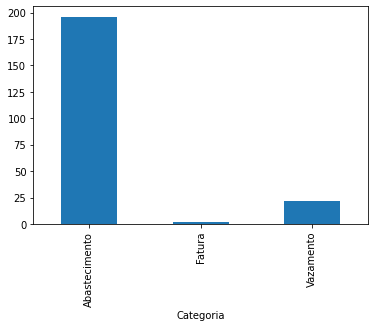

In [28]:
df_reclamacoes[df_reclamacoes['Tokens'].map(len) == 0].groupby(by="Categoria")['Texto'].count().plot.bar()

In [29]:
df_reclamacoes = df_reclamacoes[df_reclamacoes['Tokens'].map(len) > 0]
df_reclamacoes.sample(10)

,Código do serviço,Texto,Categoria,Tokens
10971,3803,Esquina com,Vazamento,[esquina]
6818,3802,Foi cortado a água indevido da sala errada,Abastecimento,"[foi, cortado, água, indevido, sala, errada]"
1176,1237,"Por gentileza , gostaria saber quando será r...",Serviços - Prazo,"[gentileza, gostaria, saber, realizado, serviç..."
3928,3802,Hoje estiveram aqui vendo pessoalmente pois ...,Abastecimento,"[hoje, aqui, vendo, pessoalmente, pois, repare..."
13111,5803,proximo a munero informado,Vazamento,"[proximo, munero, informado]"
4716,3802,Estamos sem água,Abastecimento,"[estamos, água]"
3345,3802,Apos contato em documento via telefone para ...,Abastecimento,"[apos, contato, documento, telefone, informaçõ..."
4911,3802,Dia inteiro sem água,Abastecimento,"[dia, inteiro, água]"
8215,3802,Parece ser falta água na região,Abastecimento,"[parece, ser, falta, água, região]"
1866,2017,Equipe da aguas joinville mudou hidrometro e...,Fatura,"[equipe, aguas, joinville, mudou, hidrometro, ..."


In [50]:
df_reclamacoes["Categoria"].to_excel("/content/labels.xlsx")

In [30]:
def nuvem_palavras(df, categoria):
  todos_palavras = ' '.join([token for lista in df[df["Categoria"] == categoria]["Tokens"] for token in lista])
  nuvem_palavras = WordCloud(width = 800, height = 500, max_font_size = 110,
                            collocations = False).generate(todos_palavras)

  plt.figure(figsize= (10, 7))
  plt.imshow(nuvem_palavras, interpolation = 'bilinear')
  plt.axis('off')
  plt.show()

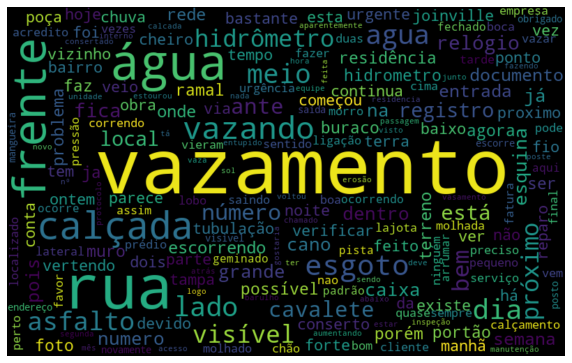

In [31]:
nuvem_palavras(df_reclamacoes, "Vazamento")

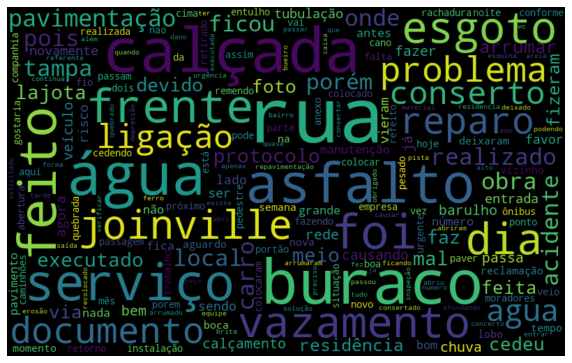

In [32]:
nuvem_palavras(df_reclamacoes, "Repavimentação")

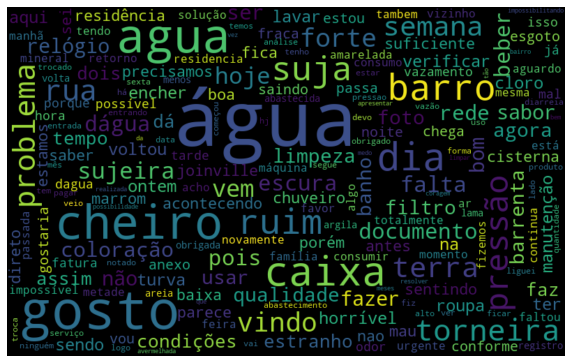

In [33]:
nuvem_palavras(df_reclamacoes, "Qualidade da Água")

## Word Embedding

In [34]:
w2v_modelo_cb = Word2Vec(sg = 0,
                         window = 2,
                         size = 300,
                         min_count = 5,
                         alpha = 0.03,
                         min_alpha = 0.007)

In [35]:
w2v_modelo_cb.build_vocab(df_reclamacoes["Tokens"], progress_per=5000)
w2v_modelo_cb.train(df_reclamacoes["Tokens"], total_examples=w2v_modelo_cb.corpus_count, epochs = 30)
w2v_modelo_cb.wv.save_word2vec_format("/content/modelo_cbow.txt", binary=False)

In [36]:
def combinacao_de_vetores_por_soma(palavras, modelo):

    vetor_resultante = np.zeros((1,300))

    for pn in palavras:
        try:
            vetor_resultante += modelo.get_vector(pn)

        except KeyError:
            pass
                

    return vetor_resultante

def matriz_vetores(lista_tokens, modelo):
    x = len(lista_tokens)
    y = 300
    matriz = np.zeros((x,y))

    for i in range(x):
        matriz[i] = combinacao_de_vetores_por_soma(lista_tokens.iloc[i], modelo)

    return matriz

In [41]:
w2v_modelo_cb = KeyedVectors.load_word2vec_format("/content/modelo_cbow.txt")
features = matriz_vetores(df_reclamacoes["Tokens"], w2v_modelo_cb)
labels = df_reclamacoes["Categoria"]

features

array([[ 9.48349618e+00,  7.58991219e+00,  5.15071494e+00, ...,
        -8.67872365e+00, -4.25370185e-01,  5.70455226e+00],
       [-3.74961572e+00, -1.19927128e+00, -3.59763781e+00, ...,
         4.20010161e+00,  2.28952265e+00, -6.26794606e+00],
       [ 1.15229349e+00,  2.11901889e+00, -4.74613777e+00, ...,
        -4.46979256e+00, -4.20830131e+00, -4.45348969e+00],
       ...,
       [-8.23709257e-02, -7.62895286e-01,  1.09502934e-01, ...,
         5.38831726e-02, -2.15497755e+00, -2.13148245e+00],
       [ 4.04784922e-01,  2.04386272e-01,  1.21542751e+00, ...,
         7.08333753e-01, -5.79786398e-01, -9.03114796e-01],
       [-7.62303546e-03,  4.98297866e-01, -4.17564265e-01, ...,
         4.56526585e-01, -3.42113301e-01,  5.09804010e-01]])

In [42]:
w2v_modelo_cb.wv.most_similar("asfalto")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('pavimento', 0.5897310972213745),
 ('calçamento', 0.5870683789253235),
 ('paralelepípedo', 0.5834174156188965),
 ('recapeamento', 0.5356777906417847),
 ('remendo', 0.5197772979736328),
 ('pavimentação', 0.5073621869087219),
 ('vala', 0.48572400212287903),
 ('camada', 0.4806380867958069),
 ('depressão', 0.47127610445022583),
 ('lajotas', 0.4636743664741516)]

In [43]:
w2v_modelo_cb.wv.most_similar("fatura")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('vencimento', 0.6452154517173767),
 ('conta', 0.6428428888320923),
 ('abril', 0.6154558062553406),
 ('faturas', 0.5757554173469543),
 ('faturamento', 0.568061113357544),
 ('cobrado', 0.5434598326683044),
 ('condição', 0.5347556471824646),
 ('valores', 0.5327302813529968),
 ('taxa', 0.5303610563278198),
 ('cúbicos', 0.5287669897079468)]

# Modelos de multiclassificação

## Validação Cruzada e escolha do modelo

In [ ]:
modelos = [
    LinearSVC(random_state=0),
    RandomForestClassifier(max_depth=5, random_state=0),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(modelos)))

entradas = []
for modelo in modelos:
  nome_modelo = modelo.__class__.__name__
  acuracias = cross_val_score(modelo, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, acuracia in enumerate(acuracias):
    entradas.append((nome_modelo, fold_idx, acuracia))
    
cv_df = pd.DataFrame(entradas, columns=['nome_modelo', 'fold_idx', 'acuracia'])

In [52]:
mean_accuracy = cv_df.groupby('nome_modelo').acuracia.mean()
std_accuracy = cv_df.groupby('nome_modelo').acuracia.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Acurácia média', 'Desvio Padrão']
acc

,Acurácia média,Desvio Padrão
nome_modelo,,
LinearSVC,0.876310,0.013247
LogisticRegression,0.875824,0.012487
RandomForestClassifier,0.840552,0.010034


Text(0.5, 1.0, 'ACURÁCIA MÉDIA (cv = 5)\n')

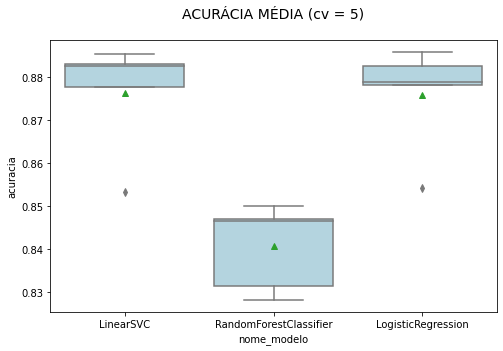

In [53]:
plt.figure(figsize=(8,5))
sns.boxplot(x='nome_modelo', y='acuracia', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("ACURÁCIA MÉDIA (cv = 5)\n", size=14)

## Avaliação do Modelo de Regressão Logística - CBOW

In [54]:
treino, teste = train_test_split(df_reclamacoes, test_size=0.2, stratify=df_reclamacoes['Categoria'])

In [55]:
def classificador(modelo, x_treino, y_treino, x_teste, y_teste):

    RL = LogisticRegression(max_iter = 800)
    RL.fit(x_treino, y_treino)
    y_previsto = RL.predict(x_teste)
    resultados = classification_report(y_teste, y_previsto)

    mc = confusion_matrix(y_teste, y_previsto)

    print(resultados)
    
    return RL, y_previsto

In [56]:
matriz_vetores_treino_cb = matriz_vetores(treino["Tokens"], w2v_modelo_cb)
matriz_vetores_teste_cb = matriz_vetores(teste["Tokens"], w2v_modelo_cb)

RL_cb, y_previsto_cb = classificador(w2v_modelo_cb,
                        matriz_vetores_treino_cb,
                        treino["Categoria"],
                        matriz_vetores_teste_cb,
                        teste["Categoria"])

                      precision    recall  f1-score   support

       Abastecimento       0.92      0.95      0.94      1469
              Fatura       0.86      0.74      0.79       236
               Obras       0.00      0.00      0.00         2
              Outros       0.00      0.00      0.00         1
   Qualidade da Água       0.74      0.64      0.69        45
      Repavimentação       0.83      0.78      0.80       231
    Serviços - Prazo       0.50      0.33      0.40         9
Serviços - Qualidade       0.33      0.14      0.20         7
           Vazamento       0.86      0.88      0.87       887

            accuracy                           0.89      2887
           macro avg       0.56      0.50      0.52      2887
        weighted avg       0.88      0.89      0.88      2887



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

In [57]:
def matriz_confusao(y_teste, y_previsto):
    mc = confusion_matrix(y_teste, y_previsto)

    fig, ax = plt.subplots(figsize=(10,8))
    rotulos = y_teste.unique()
    rotulos.sort()
    sns.heatmap(mc, annot=True,fmt='d',cmap='BuPu',xticklabels=rotulos,yticklabels=rotulos)
    plt.ylabel('Real')
    plt.xlabel('Previsto')
    plt.show()

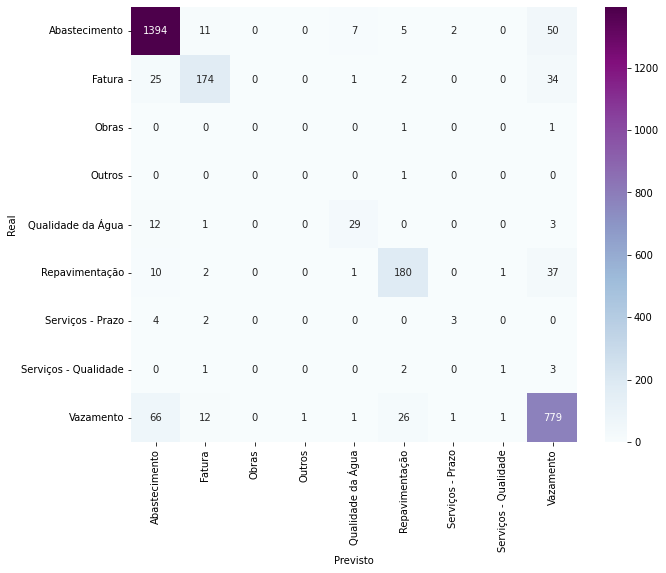

In [58]:
matriz_confusao(teste["Categoria"], y_previsto_cb)

In [59]:
def calcular_tpr_fpr(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    tpr =  TP/(TP + FN)
    fpr = 1 - TN/(TN+FP)
    
    return tpr, fpr

def get_n_roc_coordinates(y_real, y_proba, n = 50):
    tpr_lista = [0]
    fpr_lista = [0]
    for i in range(n):
        limiar = i/n
        y_pred = y_proba > limiar
        tpr, fpr = calcular_tpr_fpr(y_real, y_pred)
        tpr_lista.append(tpr)
        fpr_lista.append(fpr)

    return tpr_lista, fpr_lista

def calcular_todos_roc_auc_ovr(modelo, x_teste, y_teste):
  bins = [i/20 for i in range(20)] + [1]
  
  classes = modelo.classes_
  y_proba = modelo.predict_proba(x_teste)
  roc_auc_ovr = {}
  for i in range(len(classes)): # 
      c = classes[i]
      
      df_aux = pd.DataFrame(x_teste.copy())
      df_aux['classe'] = [1 if y == c else 0 for y in y_teste]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)

      roc_auc_ovr[c] = roc_auc_score(df_aux['classe'], df_aux['prob'])

  return roc_auc_ovr

In [60]:
roc_auc_ovr_cb = calcular_todos_roc_auc_ovr(RL_cb, matriz_vetores_teste_cb, teste["Categoria"])

In [61]:
def analisar_roc_auc(roc_auc_ovr):
  avg_roc_auc = 0
  i = 0
  for k in roc_auc_ovr:
      avg_roc_auc += roc_auc_ovr[k]
      i += 1
      print(f"ROC AUC OvR - {k}: {roc_auc_ovr[k]:.4f}")
  media = round(avg_roc_auc/i, 4)
  print(f"ROC AUC OvR - Médio: {media}")

  return media

In [62]:
roc_auc_ovr_cb_medio = analisar_roc_auc(roc_auc_ovr_cb)

ROC AUC OvR - Abastecimento: 0.9789
ROC AUC OvR - Fatura: 0.9704
ROC AUC OvR - Obras: 0.7539
ROC AUC OvR - Outros: 0.4522
ROC AUC OvR - Qualidade da Água: 0.9462
ROC AUC OvR - Repavimentação: 0.9794
ROC AUC OvR - Serviços - Prazo: 0.9041
ROC AUC OvR - Serviços - Qualidade: 0.6552
ROC AUC OvR - Vazamento: 0.9664
ROC AUC OvR - Médio: 0.8452


In [63]:
def plotar_roc_curve(tpr, fpr, c):
  plt.figure(figsize = (5, 5))
  sns.scatterplot(x = fpr, y = tpr)
  sns.lineplot(x = fpr, y = tpr)
  sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
  plt.title(c)
  plt.xlim(-0.05, 1.05)
  plt.ylim(-0.05, 1.05)
  plt.xlabel("Taxa de Falso Positivo")
  plt.ylabel("Taxa de Verdadeiro Positivo")

def plotar_roc_auc_ovr(modelo, classe, x_teste, y_teste):
  # Plots the Probability Distributions and the ROC Curves One vs Rest
  plt.figure(figsize = (12, 8))
  bins = [i/20 for i in range(20)] + [1]
  
  y_proba = modelo.predict_proba(x_teste)
  classes = modelo.classes_
  # Prepares an auxiliar dataframe to help with the plots
  df_aux = pd.DataFrame(x_teste)
  df_aux['class'] = [1 if y == classe else 0 for y in y_teste]
  df_aux['prob'] = y_proba[:, np.where(classes == classe)[0]]
  df_aux = df_aux.reset_index(drop = True)
  
  # Calculates the ROC Coordinates and plots the ROC Curves
  tpr, fpr = get_n_roc_coordinates(df_aux['class'], df_aux['prob'])
  plotar_roc_curve(tpr, fpr, classe)

<Figure size 864x576 with 0 Axes>

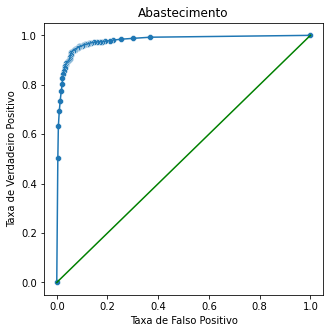

In [64]:
plotar_roc_auc_ovr(RL_cb, "Abastecimento", matriz_vetores_teste_cb, teste["Categoria"])

<Figure size 864x576 with 0 Axes>

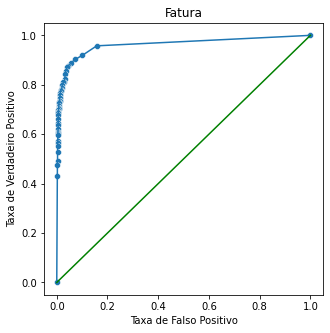

In [65]:
plotar_roc_auc_ovr(RL_cb, "Fatura", matriz_vetores_teste_cb, teste["Categoria"])

<Figure size 864x576 with 0 Axes>

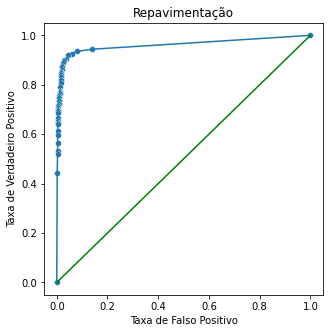

In [66]:
plotar_roc_auc_ovr(RL_cb, "Repavimentação", matriz_vetores_teste_cb, teste["Categoria"])

<Figure size 864x576 with 0 Axes>

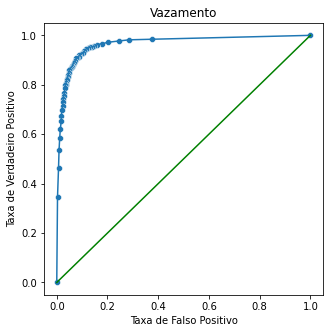

In [67]:
plotar_roc_auc_ovr(RL_cb, "Vazamento", matriz_vetores_teste_cb, teste["Categoria"])

<Figure size 864x576 with 0 Axes>

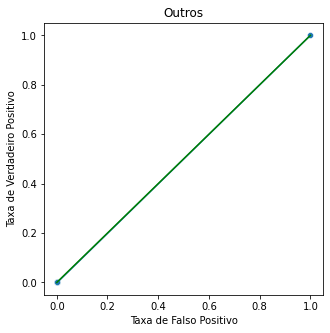

In [68]:
plotar_roc_auc_ovr(RL_cb, "Outros", matriz_vetores_teste_cb, teste["Categoria"])

## Avaliação do Modelo de Regressão Logística - Skip-Gram

In [69]:
w2v_modelo_sg = Word2Vec(sg = 1,
                      window = 5,
                      size = 300,
                      min_count = 5,
                      alpha = 0.03,
                      min_alpha = 0.007)

w2v_modelo_sg.build_vocab(df_reclamacoes["Tokens"], progress_per=5000)
w2v_modelo_sg.train(df_reclamacoes["Tokens"], total_examples=w2v_modelo_sg.corpus_count, epochs = 30)
w2v_modelo_sg.wv.save_word2vec_format("/content/modelo_skipgram.txt", binary=False)

In [70]:
w2v_modelo_sg = KeyedVectors.load_word2vec_format("/content/modelo_skipgram.txt")
matriz_vetores_treino_sg = matriz_vetores(treino["Tokens"], w2v_modelo_sg)
matriz_vetores_teste_sg = matriz_vetores(teste["Tokens"], w2v_modelo_sg)

In [71]:
RL_sg, y_previsto_sg = classificador(w2v_modelo_sg,
                                     matriz_vetores_treino_sg,
                                     treino["Categoria"],
                                     matriz_vetores_teste_sg,
                                     teste["Categoria"])

                      precision    recall  f1-score   support

       Abastecimento       0.93      0.95      0.94      1469
              Fatura       0.85      0.77      0.81       236
               Obras       0.00      0.00      0.00         2
              Outros       0.00      0.00      0.00         1
   Qualidade da Água       0.81      0.67      0.73        45
      Repavimentação       0.87      0.82      0.84       231
    Serviços - Prazo       0.38      0.33      0.35         9
Serviços - Qualidade       0.00      0.00      0.00         7
           Vazamento       0.87      0.89      0.88       887

            accuracy                           0.90      2887
           macro avg       0.52      0.49      0.51      2887
        weighted avg       0.89      0.90      0.89      2887



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

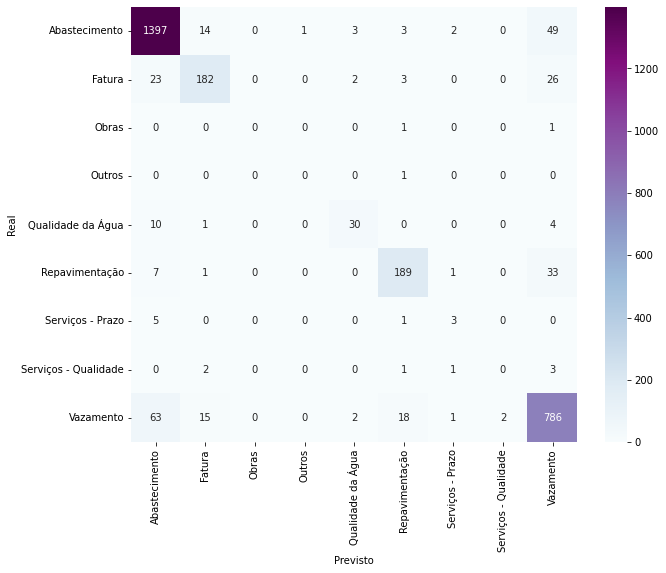

In [72]:
matriz_confusao(teste["Categoria"], y_previsto_sg)

In [73]:
roc_auc_ovr_sg = calcular_todos_roc_auc_ovr(RL_sg, matriz_vetores_teste_sg, teste["Categoria"])

In [74]:
roc_auc_ovr_sg_medio = analisar_roc_auc(roc_auc_ovr_sg)

ROC AUC OvR - Abastecimento: 0.9793
ROC AUC OvR - Fatura: 0.9662
ROC AUC OvR - Obras: 0.9215
ROC AUC OvR - Outros: 0.2765
ROC AUC OvR - Qualidade da Água: 0.9384
ROC AUC OvR - Repavimentação: 0.9783
ROC AUC OvR - Serviços - Prazo: 0.8695
ROC AUC OvR - Serviços - Qualidade: 0.6639
ROC AUC OvR - Vazamento: 0.9657
ROC AUC OvR - Médio: 0.8399


<Figure size 864x576 with 0 Axes>

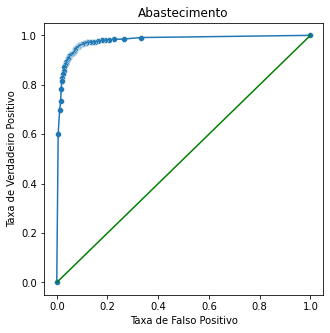

In [75]:
plotar_roc_auc_ovr(RL_sg, "Abastecimento", matriz_vetores_teste_sg, teste["Categoria"])

<Figure size 864x576 with 0 Axes>

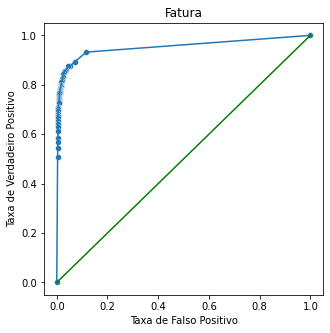

In [76]:
plotar_roc_auc_ovr(RL_sg, "Fatura", matriz_vetores_teste_sg, teste["Categoria"])

<Figure size 864x576 with 0 Axes>

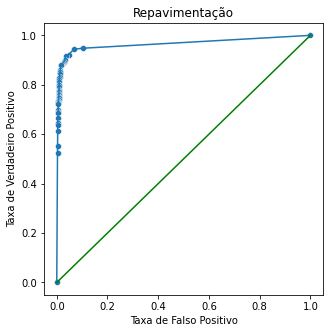

In [77]:
plotar_roc_auc_ovr(RL_sg, "Repavimentação", matriz_vetores_teste_sg, teste["Categoria"])

<Figure size 864x576 with 0 Axes>

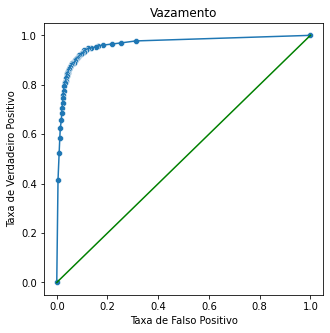

In [78]:
plotar_roc_auc_ovr(RL_sg, "Vazamento", matriz_vetores_teste_sg, teste["Categoria"])

<Figure size 864x576 with 0 Axes>

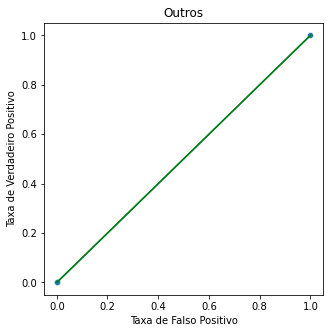

In [79]:
plotar_roc_auc_ovr(RL_sg, "Outros", matriz_vetores_teste_sg, teste["Categoria"])